<a href="https://colab.research.google.com/github/Nishitha-12/MiniProj2022/blob/main/Mini_proj_Tubercolosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import imageio
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
import shutil
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.figure_factory as ff

%matplotlib inline

In [ ]:
cd kaggle

[Errno 2] No such file or directory: 'kaggle'
/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New section

# New section

In [ ]:
cd ..

/


In [ ]:
data_tb=pd.read_csv('/content/drive/MyDrive/kaggle/shenzhen_metadata.csv')
data_tb

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal
...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...


In [ ]:
ls

In [ ]:
pip install pillow

In [ ]:
from PIL import Image
im=Image.open('/content/drive/MyDrive/kaggle/images/images/CHNCXR_0001_0.png')
im.show()



In [ ]:
dat = ff.create_table(data_tb.head())
py.iplot(dat)

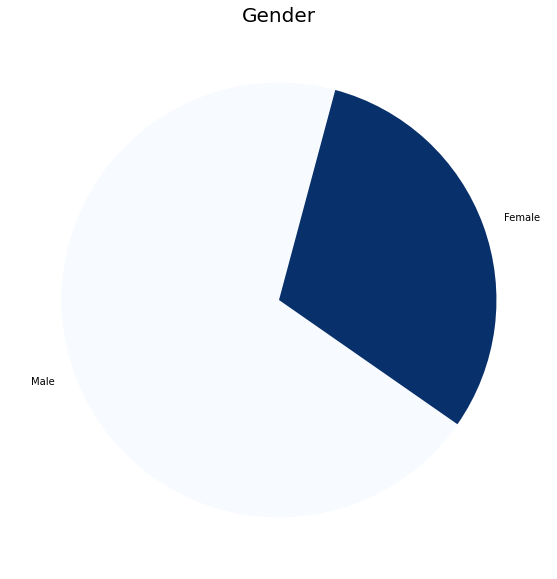

In [ ]:
color = plt.cm.Blues(np.linspace(0, 1, 2))
data_tb['sex'].value_counts().plot.pie(colors = color, figsize = (10, 10), startangle = 75)

plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.show()

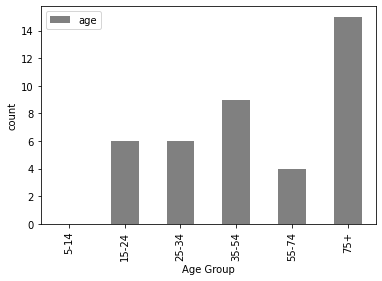

In [ ]:
# replacing categorical values in the age column

data_tb['age'] = data_tb['age'].replace('5-14 years', 0)
data_tb['age'] = data_tb['age'].replace('15-24 years', 1)
data_tb['age'] = data_tb['age'].replace('25-34 years', 2)
data_tb['age'] = data_tb['age'].replace('35-54 years', 3)
data_tb['age'] = data_tb['age'].replace('55-74 years', 4)
data_tb['age'] = data_tb['age'].replace('75+ years', 5)

#data['age'].value_counts()

# suicides in different age groups

x1 = data_tb[data_tb['age'] == 0].sum()
x2 = data_tb[data_tb['age'] == 1].sum()
x3 = data_tb[data_tb['age'] == 2].sum()
x4 = data_tb[data_tb['age'] == 3].sum()
x5 = data_tb[data_tb['age'] == 4].sum()
x6 = data_tb[data_tb['age'] == 5].sum()

x = pd.DataFrame([x1, x2, x3, x4, x5, x6])
x.index = ['5-14', '15-24', '25-34', '35-54', '55-74', '75+']
x.plot(kind = 'bar', color = 'grey')

plt.xlabel('Age Group')
plt.ylabel('count')
plt.show()

In [ ]:
data_tb['findings'].value_counts()

normal                                                    326
bilateral PTB                                              61
Right PTB                                                  45
PTB in the right upper field                               27
STB                                                        19
                                                         ... 
left upper PTB, left pleurisy                               1
right PTB,right pneumothorax                                1
right upper field PTB                                       1
right secondary PTB  with bilateral  pleurisy               1
bilateral secondary PTB  with right pleural thickening      1
Name: findings, Length: 75, dtype: int64

In [ ]:
def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [ ]:
data_tb['target'] = data_tb['study_id'].apply(extract_target)

In [ ]:
print(data_tb['target'])

0            Normal
1            Normal
2            Normal
3            Normal
4            Normal
           ...     
657    Tuberculosis
658    Tuberculosis
659    Tuberculosis
660    Tuberculosis
661    Tuberculosis
Name: target, Length: 662, dtype: object


In [ ]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories)))
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) 
        for j in range(0,figure_cols):
            file = IMAGE_PATH + sample.iloc[j]['study_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()

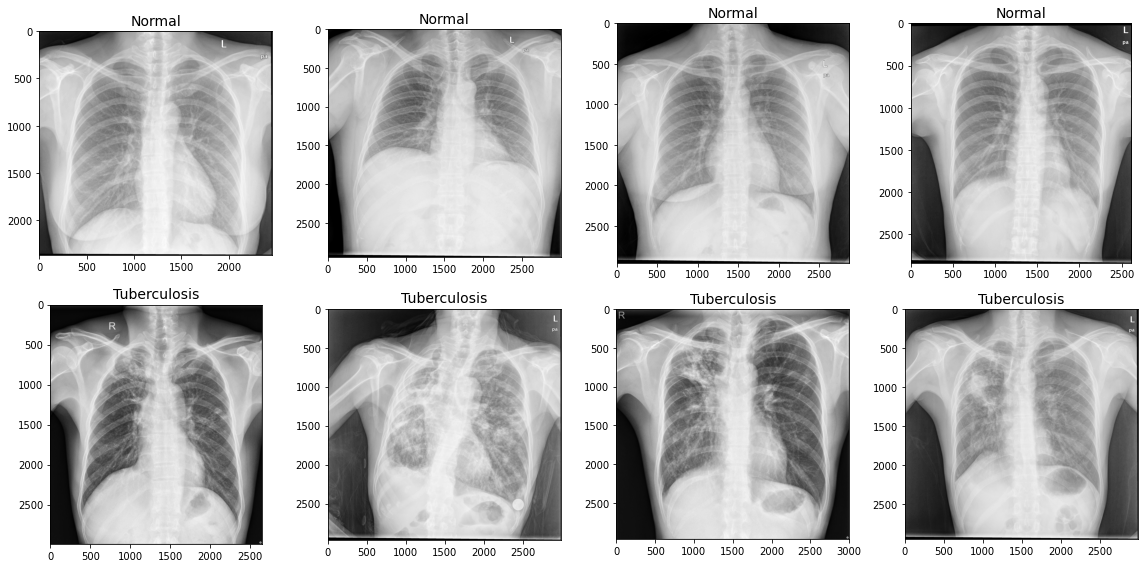

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/kaggle/images/images/' 
draw_category_images('target',4, data_tb, IMAGE_PATH)

In [ ]:
IMAGE_PATH = 'kaggle/images/images/' 

In [ ]:
cd MyDrive

/content/drive/MyDrive


In [ ]:
def read_image_sizes(file_name):
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
   
    if len(image.shape) > 2:
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [ ]:
m = np.stack(data_tb['study_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
data_tb = pd.concat([data_tb,df],axis=1, sort=False)

data_tb.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-7bcd152bd680>", line 1, in <module>
    m = np.stack(data_tb['study_id'].apply(read_image_sizes))
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/series.py", line 4357, in apply
    return SeriesApply(self, func, convert_dtype, args, kwargs).apply()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py", line 1043, in apply
    return self.apply_standard()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/apply.py", line 1101, in apply_standard
    convert=self.convert_dtype,
  File "pandas/_libs/lib.pyx", line 2859, in pandas._libs.lib.map_infer
  File "<ipython-input-40-2cd109c8f7b1>", line 3, in read_image_sizes
    max_pixel_val = image.max()
AttributeError: 'NoneType' object has no attribute 'max'

During handling of the above exce

AttributeError: ignored

In [ ]:
data_tb['c'].value_counts()

3    662
Name: c, dtype: int64

In [ ]:
data_tb['labels'] = data_tb['target'].map({'Normal':0, 'Tuberculosis':1})

In [ ]:
data_tb

,study_id,sex,age,findings,target,labels
0,CHNCXR_0001_0.png,Male,45,normal,Not TB,NaN
1,CHNCXR_0002_0.png,Male,63,normal,Not TB,NaN
2,CHNCXR_0003_0.png,Female,48,normal,Not TB,NaN
3,CHNCXR_0004_0.png,Male,58,normal,Not TB,NaN
4,CHNCXR_0005_0.png,Male,28,normal,Not TB,NaN
...,...,...,...,...,...,...
657,CHNCXR_0658_1.png,Male,41,bilateral secondary PTB with right pneumothorax,Tuberculosis,1.0
658,CHNCXR_0659_1.png,Male,33,secondary PTB in the left upper field,Tuberculosis,1.0
659,CHNCXR_0660_1.png,Male,50,1.bilateral secondary PTB with right upper at...,Tuberculosis,1.0
660,CHNCXR_0661_1.png,Male,26,bilateral secondary PTB with right pleural th...,Tuberculosis,1.0


In [ ]:
y = data_tb['labels']

df_train, df_val = train_test_split(data_tb, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

ValueError: ignored

In [ ]:
df_train['target'].value_counts()

Tuberculosis    285
Normal          277
Name: target, dtype: int64

In [ ]:
df_val['target'].value_counts()

Tuberculosis    51
Normal          49
Name: target, dtype: int64

In [ ]:
base_dir = 'base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-7239340b0109>", line 2, in <module>
    os.mkdir(base_dir)
OSError: [Errno 107] Transport endpoint is not connected: 'base_dir'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/I

OSError: ignored

In [ ]:
data_tb.set_index('study_id', inplace=True)

In [ ]:
data_tb.head()

,sex,age,findings,target,w,h,c,max_pixel_val,min_pixel_val,labels
study_id,,,,,,,,,,
CHNCXR_0001_0.png,Male,45,normal,Normal,2919,3000,3,255,0,0
CHNCXR_0002_0.png,Male,63,normal,Normal,2951,3000,3,255,0,0
CHNCXR_0003_0.png,Female,48,normal,Normal,2945,2987,3,255,0,0
CHNCXR_0004_0.png,Male,58,normal,Normal,2933,3000,3,255,0,0
CHNCXR_0005_0.png,Male,28,normal,Normal,2933,3000,3,255,0,0


In [ ]:
NUM_AUG_IMAGES_WANTED = 1000 

# We will resize the images
IMAGE_HEIGHT = 40
IMAGE_WIDTH = 40

In [ ]:
folder_1 = os.listdir('kaggle/images/images/')
# Get a list of train and val images
train_list = list(df_train['study_id'])
val_list = list(df_val['study_id'])

# Transfer the train images

for image in train_list:
    
    fname = image
    label = data_tb.loc[image,'target']
    
    if fname in folder_1:
        src = os.path.join('kaggle/images/images/', fname)
        dst = os.path.join(train_dir, label, fname)
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

for image in val_list:
    
    fname = image
    label = data_tb.loc[image,'target']
    
    if fname in folder_1:
        src = os.path.join('kaggle/images/images/', fname)
        dst = os.path.join(val_dir, label, fname)
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)

In [ ]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

277
285


In [ ]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

49
51


In [ ]:
class_list = ['Normal','Tuberculosis']

for item in class_list:
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    
    
    
    
    num_files = len(os.listdir(img_dir))
    
    num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 277 images belonging to 1 classes.
Found 285 images belonging to 1 classes.


In [ ]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

981
1005


In [ ]:
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

49
51


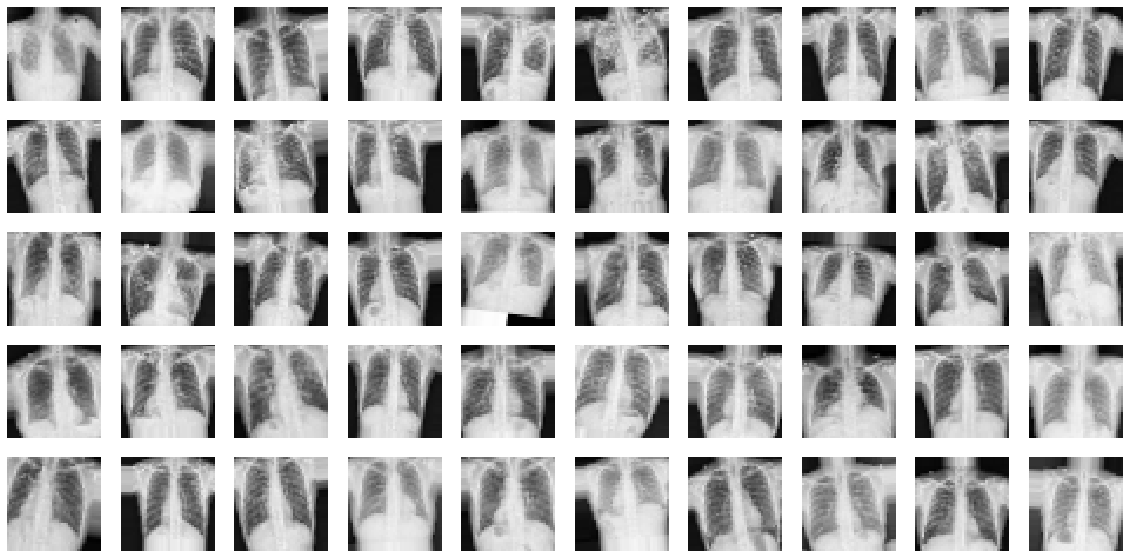

In [ ]:
def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
plots(imgs, titles=None)

In [ ]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1986 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 17, 17, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 64)        18496     
                                                        

In [ ]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
aug_dir_1 = 'model5'
os.mkdir(aug_dir_1)
filepath = "kaggle/working/model5/model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=100, verbose=1,
                           callbacks=callbacks_list)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.7473
Epoch 1: val_accuracy improved from -inf to 0.74000, saving model to kaggle/working/model5/model.h5
57/57 [==============================] - 7s 118ms/step - loss: 0.5323 - accuracy: 0.7473 - val_loss: 0.5368 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.5227 - accuracy: 0.7667
Epoch 2: val_accuracy did not improve from 0.74000
57/57 [==============================] - 7s 120ms/step - loss: 0.5227 - accuracy: 0.7667 - val_loss: 0.5314 - val_accuracy: 0.7400 - lr: 1.0000e-04
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.7965
Epoch 3: val_accuracy did not improve from 0.74000

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
57/57 [==============================] - 7s 124ms/step - loss: 0.4835 - accuracy: 0.7965 - val_loss: 0.5524 - val_accuracy: 0.7200 - lr: 1.0

In [ ]:
model.metrics_names

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-50796fac6b0a>", line 1, in <module>
    model.metrics_names
NameError: name 'model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", li

NameError: ignored

In [ ]:
val_loss, val_acc = \
model.evaluate(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

10/10 [==============================] - 0s 35ms/step - loss: 0.5080 - accuracy: 0.7500
val_loss: 0.5079694986343384
val_acc: 0.75


In [ ]:
!ls

 base_dir	    data    kaggle   Processed-Heart-Detection
'Colab Notebooks'   heart   model5   Tubercolosis


In [ ]:
test_labels = test_gen.classes

In [ ]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
predictions = model.predict(test_gen, steps=val_steps, verbose=1)

10/10 [==============================] - 1s 69ms/step


In [ ]:
predictions.shape

(100, 2)

In [ ]:
test_labels.shape

NameError: ignored

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

NameError: ignored

In [ ]:
test_gen.class_indices

{'Normal': 0, 'Tuberculosis': 1}

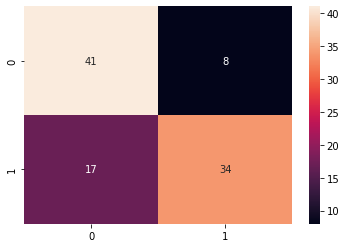

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)